# Makemore - Activations & Gradients, BatchNorm

## Imports

In [2]:
import torch 
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt 

%matplotlib inline
#%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

In [1]:
SEED = 2147483647

## Dataset

In [3]:
# reading the dataset 
words = open('name.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# Look up for characters
chars = sorted(set(''.join(words)))
stoi = {s : i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()} 

# Dictornary key, value and in enumerate index, value (column_names, values)

In [5]:
# Dataset 
def build_dataset(words):
    block_size = 3
    context = []
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
            

In [6]:
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Model

### MLP revisted 

In [ ]:
n_embb = 10  # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in hidden layer
vocab_size = len(itos) 
block_size = 3

g = torch.Generator().manual_seed(SEED)
C = torch.randn(size=(vocab_size, n_embb),              generator=g) #
W1 = torch.randn(size=(block_size * n_embb, n_hidden),  generator=g)
b1 = torch.randn(n_hidden,                              generator=g)
W2 = torch.randn(size=(n_hidden, vocab_size),           generator=g)
b2 = torch.randn(vocab_size,                            generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


11897


In [ ]:
def train(max_steps, batch_size, lossi, g):
    for i in range(max_steps):

        # min batch 
        ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]

        # first layer 
        emb = C[Xb]
        embcat = emb.view(emb.shape[0], -1)

        # hidden layer 
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)

        # third layer
        logits = h @ W2 + b2
        
        # loss 
        loss = F.cross_entropy(logits, Yb)

        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = 0.1 if i < 100000 else 0.01
        for p in parameters:
            p.data += -lr * p.grad
        
        # stats
        if i % 10000 == 0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
            
        lossi.append(loss.log10().item())


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(SEED)

%time train(max_steps, batch_size, lossi, g)


      0/ 200000: 27.1911
  10000/ 200000: 2.2061
  20000/ 200000: 2.4354
  30000/ 200000: 2.4549
  40000/ 200000: 2.1549
  50000/ 200000: 2.5022
  60000/ 200000: 2.1099
  70000/ 200000: 2.2633
  80000/ 200000: 2.6464
  90000/ 200000: 1.9474
 100000/ 200000: 2.3580
 110000/ 200000: 2.1949
 120000/ 200000: 2.1472
 130000/ 200000: 1.7711
 140000/ 200000: 2.2109
 150000/ 200000: 2.3094
 160000/ 200000: 2.1037
 170000/ 200000: 1.7047
 180000/ 200000: 2.5600
 190000/ 200000: 2.2778
CPU times: user 4min 25s, sys: 1.22 s, total: 4min 27s
Wall time: 2min 13s


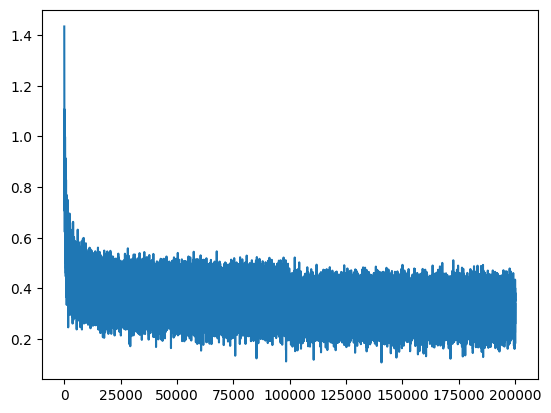

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': [Xtr, Ytr],
        'dev' : [Xdev, Ydev],
        'test' : [Xte, Yte]
    }[split]
    emb = C[x]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')
split_loss('test')

train 2.1255719661712646
dev 2.1697864532470703
test 2.164987325668335


In [ ]:
# Sampling 

g = torch.Generator().manual_seed(SEED + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, 1)
        ix = torch.multinomial(prob, num_samples=1, generator=g).item()
        out.append(ix)
        context = context[1:] + [ix]
        if ix == 0:
            break
    print(''.join(itos[c] for c in out))



mora.
mayah.
see.
mad.
ryla.
rethrettadrie.
razered.
eliigh.
parelle.
elissopharleit.
korvara.
noshubergah.
mies.
jacer.
jeniquettochuz.
zayveer.
yarue.
ehs.
kaysh.
skylan.


### Fixing 

In [7]:
# Intially when we are running our model we are getting a loss of 27 which way too high 
# but at the intial state the probability for each of the character in our vocab should have equal probabality as every character will be equally likely 
# but when we are intializing neural network is creating probabilities that are almost up some character have very high probability and some have very less
# so our neural network is very confidently wrong that make it record very high loss 

# A 4-dimenssional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0]) 
prob = torch.softmax(logits, dim=0)
loss = -prob[2].log()

# here all the probabilities are same and so the loss will be the same it doesn't matter which is the true label 
# but if we change the logits and make them not equally likely then the loss will change if we assign a higher value 
# to our true label then loss will be low because we will be assign high probability for the true label and vice versa

logits_1 = torch.tensor([0.0, 0.0, 5.0, 0.0]) 
logits_2 = torch.tensor([0.0, 5.0, .0, 0.0]) 
prob_1 = torch.softmax(logits_1, dim=0)
loss_1 = -prob_1[2].log()
prob_2 = torch.softmax(logits_2, dim=0)
loss_2 = -prob_2[2].log()
prob, loss, prob_1, loss_1, prob_2, loss_2

(tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863),
 tensor([0.0066, 0.0066, 0.9802, 0.0066]),
 tensor(0.0200),
 tensor([0.0066, 0.9802, 0.0066, 0.0066]),
 tensor(5.0200))

In [8]:
n_embb = 10  # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in hidden layer
vocab_size = len(itos) 
block_size = 3

g = torch.Generator().manual_seed(SEED)
C = torch.randn(size=(vocab_size, n_embb),              generator=g) #
W1 = torch.randn(size=(block_size * n_embb, n_hidden),  generator=g) * 0.2
b1 = torch.randn(n_hidden,                              generator=g) * 0
W2 = torch.randn(size=(n_hidden, vocab_size),           generator=g) * 0.01 
b2 = torch.randn(vocab_size,                            generator=g) * 0 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


11897


In [9]:
max_steps = 200000
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(SEED)


for i in range(max_steps):

    # min batch 
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    # first layer 
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    # hidden layer 
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    # third layer
    logits = h @ W2 + b2
    
    # loss 
    loss = F.cross_entropy(logits, Yb)
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.log10().item())

    #break

      0/ 200000: 3.3071


  10000/ 200000: 2.0377
  20000/ 200000: 2.3303
  30000/ 200000: 2.2041
  40000/ 200000: 2.0221
  50000/ 200000: 2.3013
  60000/ 200000: 1.9124
  70000/ 200000: 2.0350
  80000/ 200000: 2.1547
  90000/ 200000: 1.9577
 100000/ 200000: 2.1940
 110000/ 200000: 2.0594
 120000/ 200000: 2.0821
 130000/ 200000: 1.6454
 140000/ 200000: 2.1704
 150000/ 200000: 2.2363
 160000/ 200000: 2.0752
 170000/ 200000: 1.6821
 180000/ 200000: 2.5423
 190000/ 200000: 2.2485


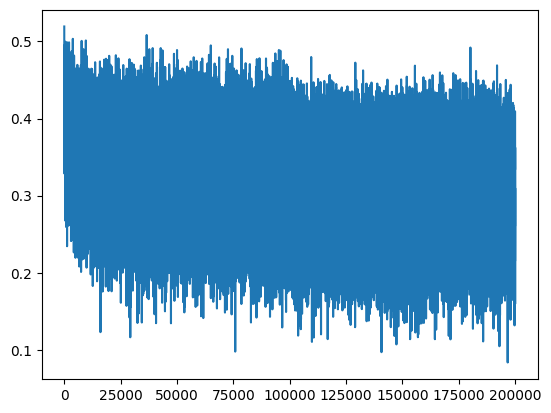

In [10]:
plt.plot(lossi)

In [11]:
# Another issue is our h 
h
# here we can se that lots of our value are 1, and -1 

tensor([[ 0.9718,  0.9991, -0.9989,  ..., -0.3648, -0.8963,  0.9992],
        [ 0.9992,  0.6575, -0.2612,  ..., -0.9974,  0.8933,  0.9207],
        [-0.9365, -0.6654,  0.4718,  ...,  0.9480, -0.9803,  0.9528],
        ...,
        [-0.0975, -0.2214, -0.9480,  ...,  0.9934, -0.9613,  0.8199],
        [-0.9816, -0.3030,  0.7724,  ...,  0.5080, -0.9933,  0.9931],
        [ 0.9628, -0.7532,  0.9462,  ..., -1.0000,  0.9930,  0.9535]],
       grad_fn=<TanhBackward0>)

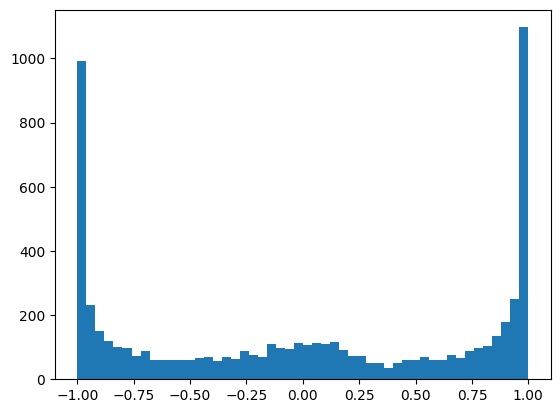

In [12]:
plt.hist(h.view(-1).tolist(), bins=50);
# most of our values are 1 or -1 this is because torch.tanh squash the value between -1 and 1 

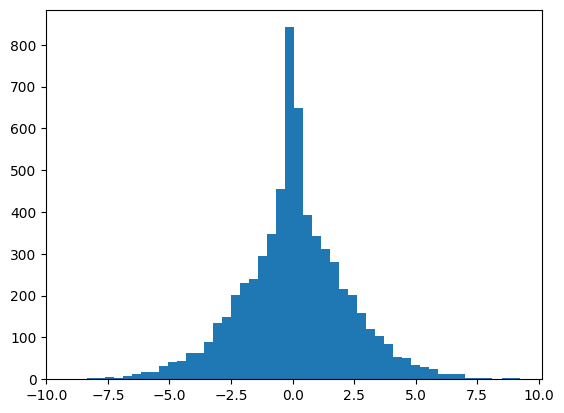

In [13]:
plt.hist(hpreact.view(-1).tolist(), 50);
# our values are spread bewteen -20 to 20 so a lots of values are getting squashed into -1 and 1 
# why this is a problem because of backpropagation 


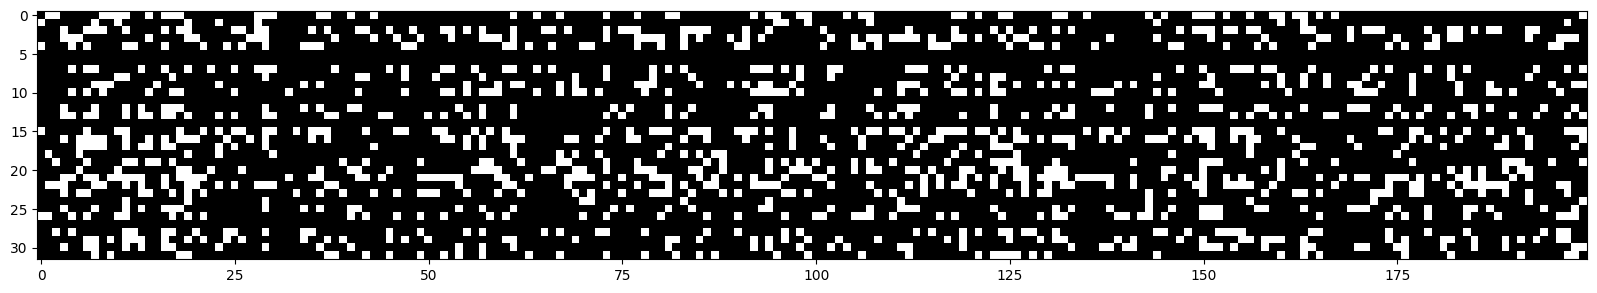

In [14]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='grey', interpolation='nearest')
# what we are doing in this plot is we are checking how offen our values are above 0.99 
# this is a boolean map and white tiles shows true and grey shows false
# observation : most of the values are greater than 0.99 


# we will be in lot of trouble if anyone of the entire column would be white in that case we will have a dead neuron 
# in such a case the intiallization of weight and biases could be such that no single example ever activates this tanh in sort of active part of tanh 
# if all the examples land in the tail then this neuron will never learn it is a dead neuron


In [15]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': [Xtr, Ytr],
        'dev' : [Xdev, Ydev],
        'test' : [Xte, Yte]
    }[split]
    emb = C[x]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')
split_loss('test')

train 2.035069227218628
dev 2.1041553020477295
test 2.1000072956085205
